THIS IS A WORK IN PROGRESS

0    549
1    342
Name: Survived, dtype: int64


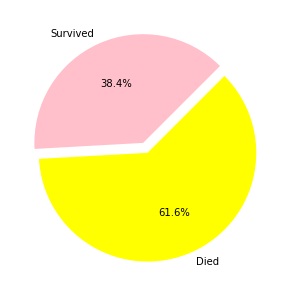

In [17]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

train = pd.read_csv('scaled_training_data.csv',index_col='PassengerId')
print(train['Survived'].value_counts())
fig = plt.figure(figsize=(5,5))
colors = ["pink",'yellow']
surv = train[train['Survived']==1]
died = train[train['Survived']==0]
ck = [surv['Survived'].count(),died['Survived'].count()]
piechart = plt.pie(ck,labels=["Survived","Died"],
autopct ='%1.1f%%',
colors = colors,
startangle = 45,
explode=(0, 0.1))

In [18]:
X_train = train.drop('Survived',axis=1).values
y_train = train['Survived'].values
logreg = LogisticRegression()
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=32)
log_cv_results = cross_val_score(logreg, X_train, y_train, cv=kf)
print(np.mean(log_cv_results))

0.8181532860460738


In [22]:
#Try tuning
param_grid = {'solver':['newton-cg','lbfgs','sag'],'penalty':['None','l2'],'C':[150, 100, 10, 1.0, 0.1, 0.01]}
logreg_grid = GridSearchCV(logreg, param_grid, cv=kf)
logreg_grid.fit(X_train,y_train)
print(logreg_grid.best_params_, logreg_grid.best_score_)

C:\Users\Gabbi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Gabbi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/m

C:\Users\Gabbi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Gabbi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/m

{'C': 10, 'penalty': 'l2', 'solver': 'sag'} 0.8203879229175822


C:\Users\Gabbi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
90 fits failed out of a total of 180.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
30 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Gabbi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Gabbi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages

In [26]:
import xgboost as xgb

X = train.drop('Survived',axis=1)
y = train['Survived']
dmatrix = xgb.DMatrix(data=X, label=y)
params = {"objective":"binary:logistic","max_depth":4}
gbm = xgb.XGBClassifier()
boost_cv_results = xgb.cv(dtrain=dmatrix, params=params, nfold=5, num_boost_round=100, metrics="error", 
                          as_pandas=True,stratified=True)
print("Accuracy: %f" %((1-boost_cv_results["test-error-mean"]).iloc[-1]))

Accuracy: 0.822635


In [27]:
#Try tuning
gbm_param_grid = {'learning_rate': [0.01,0.1,0.4,0.6,0.9],'n_estimators': [200], 'subsample': np.arange(0.3,1.1,0.1),
                 'objective':["binary:logistic"], 'colsample_bytree':np.arange(0.1,1.1,0.1),'max_depth': np.arange(3,20)}
tune_boost_cv = RandomizedSearchCV(estimator=gbm, param_distributions=gbm_param_grid,scoring='accuracy', 
                                   n_iter=100, cv=kf, verbose=1)
#tune_boost_cv = GridSearchCV(estimator=gbm, param_grid=gbm_param_grid,scoring='accuracy', cv=kf, verbose=1)
tune_boost_cv.fit(X,y)
print(tune_boost_cv.best_params_,tune_boost_cv.best_score_)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
{'subsample': 0.5, 'objective': 'binary:logistic', 'n_estimators': 200, 'max_depth': 19, 'learning_rate': 0.1, 'colsample_bytree': 0.4} 0.8349632791412969


In [23]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=200)
rf_cv_results = cross_val_score(rf, X_train, y_train, cv=kf)
print(np.mean(rf_cv_results))

0.8057811813445485


In [24]:
#Try tuning
rf_param_grid = {'n_estimators': [150,200,300], 'min_samples_leaf': [1, 2, 4],'max_depth': np.arange(3,20),
                 'min_samples_split': [2, 5, 10]}
rf_tuned = RandomForestClassifier()
#rf_cv = GridSearchCV(estimator=rf_tuned, param_grid=rf_param_grid,scoring='accuracy', cv=kf, verbose=1)
rf_cv = RandomizedSearchCV(estimator=rf_tuned, param_distributions=rf_param_grid,n_iter=50,scoring='accuracy', cv=kf, verbose=1)
rf_cv.fit(X_train,y_train)
print(rf_cv.best_params_,rf_cv.best_score_)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
{'n_estimators': 200, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_depth': 19} 0.8394702153034963
